<a href="https://colab.research.google.com/github/tkassahu/clinical-trial-attrition-prediction/blob/main/Project3_Group3b_ClinicalAttrition_FeatureEngineering_DataProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Patients’ Attrition Percentage in Clinical Trials

---


Project 3 - Group 3B



---

### **Primary Goal**: Develop a machine learning model capable of predicting patient attrition percentages in clinical trials using specific features


This notebook covers the steps for **Feature Engineering** and **Data Processing**

## **1. Feature Engineering**

### Step 1.1. Feature Extraction

#### Load the Attrition Dataset

In [ ]:
# Install necessary packages
!pip install pyzipcode
import requests
from pyzipcode import ZipCodeDatabase
import folium
import pandas as pd
import numpy as np

In [ ]:
# Mounting Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define path and load data
ct_attrition = "/content/drive/MyDrive/Georgetown University/HIDS/HIDS-6001/Project 3/Working Files/Data"
attrition_df = pd.read_csv(ct_attrition + "/ct_attrition_dataset.csv")

In [ ]:
# Sneakpeak at the datafram
attrition_df.head()

,nct_id,dropout_percentage_all
0,NCT00001596,17.391304
1,NCT00001723,8.000000
2,NCT00003869,21.877891
3,NCT00003901,0.859599
4,NCT00045162,24.436516


In [ ]:
# Check for any missing values
attrition_df.isna().sum()

,0
nct_id,0
dropout_percentage_all,0


In [ ]:
# Check datafram info
attrition_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1325 entries, 0 to 1324
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   nct_id                  1325 non-null   object 
 1   dropout_percentage_all  1325 non-null   float64
dtypes: float64(1), object(1)
memory usage: 20.8+ KB


#### Get Data from the JSON file via ClinicalTrials.gov API

In [ ]:
# Create a list of URLs from the 'nct_id' column
nct_list = attrition_df['nct_id']
url_series = ["https://clinicaltrials.gov/api/v2/studies/" + nct_id for nct_id in nct_list]

In [ ]:
# Initialize an empty list to store the results
studyTypes = []
enrollment_infos = []
healthy_volunteers = []
interventions_list = []
armGroups_list = []
start_date = []
completion_date = []
zip_codes_list = []
trial_phase = []
min_age = []
max_age = []
num_locations = []
total_serious_events = []
conditions = []
gender = []
masking = []
std_ages = []
who_masked = []

In [ ]:
# Loop through the list of URLs and make requests
for url in url_series:
    try:
        # Get the data from the API
        response = requests.get(url)
        response.raise_for_status()  # Ensure we catch any HTTP errors
        jsonContent = response.json()

        # Extract values from JSON, using 'Not Available' for missing fields
        studyType = jsonContent['protocolSection']['designModule'].get('studyType', 'Not Available')
        enrollmentInfo = jsonContent['protocolSection']['designModule']['enrollmentInfo'].get('count', 'Not Available')
        healthyVolunteers = jsonContent['protocolSection']['eligibilityModule'].get('healthyVolunteers', 'Not Available')
        interventions = jsonContent['protocolSection']['armsInterventionsModule'].get('interventions', [])
        armGroups = jsonContent['protocolSection']['armsInterventionsModule'].get('armGroups', [])
        startDateStruct = jsonContent['protocolSection']['statusModule'].get('startDateStruct', {})
        completionDateStruct = jsonContent['protocolSection']['statusModule'].get('completionDateStruct', {})
        locations = jsonContent['protocolSection'].get('contactsLocationsModule', {}).get('locations', [])
        phases = jsonContent['protocolSection']['designModule'].get('phases', 'Not Available')
        minimumAge = jsonContent['protocolSection']['eligibilityModule'].get('minimumAge', 'Not Available')
        maximumAge = jsonContent['protocolSection']['eligibilityModule'].get('maximumAge', 'Not Available')
        seriousEvents = jsonContent['resultsSection']['adverseEventsModule'].get('seriousEvents', [])
        conditions_name = jsonContent['protocolSection']['conditionsModule'].get('conditions', 'Not Available')
        sex = jsonContent['protocolSection']['eligibilityModule'].get('sex', 'Not Available')
        maskingInfo = jsonContent.get('protocolSection', {}).get('designModule', {}).get('designInfo', {}).get('maskingInfo', {}).get('masking', 'Not Available')
        stdAges = jsonContent['protocolSection']['eligibilityModule'].get('stdAges', 'Not Available')
        whoMasked = jsonContent.get('protocolSection', {}).get('designModule', {}).get('designInfo', {}).get('maskingInfo', {}).get('whoMasked', [])

        # Extract only the 'type' from each intervention in the list
        intervention_types = [intervention.get('type', 'Not Available') for intervention in interventions]

        # Extract only the 'type' from each armGroup in the list
        armGroups_types = [armGroup.get('type', 'Not Available') for armGroup in armGroups]

        # Extract zip codes, ensuring the location list is not empty and contains 'zip' keys
        zip_codes = [zipcode.get('zip', 'Not Available') for zipcode in locations if isinstance(zipcode, dict)]

        # Extract start and completion dates, ensuring the structures are not empty
        startDate = startDateStruct.get('date', 'Not Available') if isinstance(startDateStruct, dict) else 'Not Available'
        endDate = completionDateStruct.get('date', 'Not Available') if isinstance(completionDateStruct, dict) else 'Not Available'

        # Replace None with 'NONE' and handle empty lists by returning 'Not Available'
        whoMasked = ['NONE' if mask is None else str(mask) for mask in whoMasked]

        # Handle the case where 'Not Available' and 'NONE' should be separate
        if not whoMasked:
            whoMasked_str = 'Not Available'
        else:
            whoMasked_str = ", ".join(whoMasked)


        # Append each value to the corresponding list
        studyTypes.append(studyType)
        enrollment_infos.append(enrollmentInfo)
        healthy_volunteers.append(healthyVolunteers)
        interventions_list.append(intervention_types)
        armGroups_list.append(armGroups_types)
        start_date.append(startDate)  # Append the start date directly (as a string)
        completion_date.append(endDate)  # Append the end date directly (as a string)
        zip_codes_list.append(zip_codes)
        trial_phase.append(phases)
        min_age.append(minimumAge)
        max_age.append(maximumAge)
        num_locations.append(len(locations))
        total_serious_events.append(len(seriousEvents))
        conditions.append(conditions_name)
        gender.append(sex)
        masking.append(maskingInfo)
        std_ages.append(stdAges)
        who_masked.append(whoMasked_str)

    except requests.exceptions.RequestException as e:
        # Handle any errors with the request (e.g., timeout, non-200 status)
        print(f"Error processing {url}: {e}")

In [ ]:
# Add the new columns to the DataFrame
attrition_df['studyType'] = studyTypes
attrition_df['enrollmentInfo'] = enrollment_infos
attrition_df['healthyVolunteers'] = healthy_volunteers
attrition_df['interventions'] = interventions_list
attrition_df['armGroups'] = armGroups_list
attrition_df['startDateStruct'] = start_date
attrition_df['completionDateStruct'] = completion_date
attrition_df['zip_codes'] = zip_codes_list
attrition_df['phases'] = trial_phase
attrition_df['minimumAge'] = min_age
attrition_df['maximumAge'] = max_age
attrition_df['locations'] = num_locations
attrition_df['seriousEvents'] = total_serious_events
attrition_df['conditions_name'] = conditions
attrition_df['sex'] = gender
attrition_df['maskingInfo'] = masking
attrition_df['stdAges'] = std_ages
attrition_df['whoMasked_str'] = who_masked

In [ ]:
# Check the updated DataFrame
print(attrition_df)

           nct_id  dropout_percentage_all       studyType  enrollmentInfo  \
0     NCT00001596               17.391304  INTERVENTIONAL              35   
1     NCT00001723                8.000000  INTERVENTIONAL             200   
2     NCT00003869               21.877891  INTERVENTIONAL             186   
3     NCT00003901                0.859599  INTERVENTIONAL            1310   
4     NCT00045162               24.436516  INTERVENTIONAL             671   
...           ...                     ...             ...             ...   
1320  NCT02948582                2.777778  INTERVENTIONAL              42   
1321  NCT03005067               10.068114  INTERVENTIONAL             171   
1322  NCT03021304                0.000000  INTERVENTIONAL              56   
1323  NCT03022422               13.043478  INTERVENTIONAL              63   
1324  NCT03099096                0.628931  INTERVENTIONAL             159   

      healthyVolunteers                         interventions  \
0         

In [ ]:
#Get dataframe info
attrition_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1325 entries, 0 to 1324
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   nct_id                  1325 non-null   object 
 1   dropout_percentage_all  1325 non-null   float64
 2   studyType               1325 non-null   object 
 3   enrollmentInfo          1325 non-null   int64  
 4   healthyVolunteers       1325 non-null   bool   
 5   interventions           1325 non-null   object 
 6   armGroups               1325 non-null   object 
 7   startDateStruct         1325 non-null   object 
 8   completionDateStruct    1325 non-null   object 
 9   zip_codes               1325 non-null   object 
 10  phases                  1325 non-null   object 
 11  minimumAge              1325 non-null   object 
 12  maximumAge              1325 non-null   object 
 13  locations               1325 non-null   int64  
 14  seriousEvents           1325 non-null   

### Step 1.2. Feature Transformation and Creation

In this step, we will transform existing features one at a time and create additional features as we go.

#### Transform the 'startDateStruct' and 'completionDateStruct' to calculate 'duration'

In [ ]:
# Function to normalize the date
def normalize_date(date_str):
    if pd.isna(date_str):
        return None  # If the date is NaN, return None
    if len(date_str) == 7:  # Format is year-month (e.g., '2005-09')
        return pd.to_datetime(date_str + '-01')  # Assume the first day of the month
    else:
        return pd.to_datetime(date_str, errors='coerce')  # Convert to datetime

# Normalize startDate and completionDate
attrition_df['startDate'] = attrition_df['startDateStruct'].apply(normalize_date)
attrition_df['completionDate'] = attrition_df['completionDateStruct'].apply(normalize_date)

# Calculate the 'duration' by subtracting the start date from the completion date
attrition_df['duration'] = (attrition_df['completionDate'] - attrition_df['startDate']).dt.days


In [ ]:
# Check the result
print(attrition_df[['startDate', 'startDateStruct', 'completionDate', 'completionDateStruct', 'duration']])

      startDate startDateStruct completionDate completionDateStruct  duration
0    2005-09-01         2005-09     2016-05-09           2016-05-09    3903.0
1    1998-05-01         1998-05     2011-10-01              2011-10    4901.0
2    1999-04-01         1999-04     2008-05-01              2008-05    3318.0
3    1999-07-01         1999-07     2011-10-01              2011-10    4475.0
4    2002-11-01         2002-11     2009-12-01              2009-12    2587.0
...         ...             ...            ...                  ...       ...
1320 2010-07-01         2010-07     2010-11-01              2010-11     123.0
1321 2016-12-29      2016-12-29     2017-06-07           2017-06-07     160.0
1322 2017-02-01      2017-02-01     2017-08-08           2017-08-08     188.0
1323 2011-09-01         2011-09     2011-12-01              2011-12      91.0
1324 2017-05-04      2017-05-04     2017-11-30           2017-11-30     210.0

[1325 rows x 5 columns]


#### Transform 'whoMasked_str' and 'maskingInfo' to create 'participant_masked'

In [ ]:
# Modify the 'whoMasked_str' column based on the 'maskingInfo' column
def update_who_masked_str(row):
    if row['maskingInfo'] == 'NONE' and pd.isna(row['whoMasked_str']):
        return 'NONE'  # If maskingInfo is 'NONE' and whoMasked_str is empty, fill with 'NONE'
    elif row['maskingInfo'] == 'NONE':
        return 'NONE'  # If maskingInfo is 'NONE', fill with 'NONE'
    elif row['maskingInfo'] == 'Not Available':
        return 'Not Available'  # If maskingInfo is 'Not Available', fill with 'Not Available'
    else:
        return row['whoMasked_str']  # Otherwise, keep whoMasked_str as is

In [ ]:
# Apply the function to the DataFrame
attrition_df['whoMasked_str'] = attrition_df.apply(update_who_masked_str, axis=1)

# Verify the updated value counts
print(attrition_df['whoMasked_str'].value_counts())

whoMasked_str
NONE                                                           464
PARTICIPANT, CARE_PROVIDER, INVESTIGATOR, OUTCOMES_ASSESSOR    315
PARTICIPANT, INVESTIGATOR                                      257
PARTICIPANT, CARE_PROVIDER, INVESTIGATOR                        78
Not Available                                                   77
PARTICIPANT, INVESTIGATOR, OUTCOMES_ASSESSOR                    60
PARTICIPANT                                                     26
OUTCOMES_ASSESSOR                                               18
INVESTIGATOR                                                     8
PARTICIPANT, OUTCOMES_ASSESSOR                                   7
PARTICIPANT, CARE_PROVIDER                                       6
PARTICIPANT, CARE_PROVIDER, OUTCOMES_ASSESSOR                    6
CARE_PROVIDER, INVESTIGATOR                                      1
CARE_PROVIDER, OUTCOMES_ASSESSOR                                 1
INVESTIGATOR, OUTCOMES_ASSESSOR                 

In [ ]:
# Define a function to categorize masking status
def categorize_participant_masking(whoMasked_str):
    if pd.isnull(whoMasked_str):  # Check for null or NaN
        return 'Unknown'
    whoMasked_str = str(whoMasked_str)  # Ensure it's a string
    if whoMasked_str == 'Not Available':  # Keep "Not Available" unchanged
        return 'Not Available'
    elif 'PARTICIPANT' in whoMasked_str:
        return 'Participant Masked'
    else:
        return 'Not Masked'

# Apply the function to create a new column
attrition_df['masking_category'] = attrition_df['whoMasked_str'].apply(categorize_participant_masking)

In [ ]:
# Check the value counts for the new column
print(attrition_df['masking_category'].value_counts())

masking_category
Participant Masked    755
Not Masked            493
Not Available          77
Name: count, dtype: int64


In [ ]:
# Rename the column to 'participant_masked'
attrition_df.rename(columns={'masking_category': 'participant_masked'}, inplace=True)

# Apply the transformation
attrition_df['participant_masked'] = attrition_df['participant_masked'].replace({
    'Participant Masked': 1,
    'Not Masked': 0,
    'Not Available': pd.NA
})

# Check the changes
print(attrition_df[['participant_masked']].head())

  participant_masked
0                  1
1                  1
2                  1
3                  0
4                  0


In [ ]:
print(attrition_df['participant_masked'].value_counts())

participant_masked
1    755
0    493
Name: count, dtype: int64


#### Create bins from 'interventions' then apply one-hot encoding

In [ ]:
# Modify 'interventions' to 'multiple' if more than one intervention
attrition_df['interventions'] = attrition_df['interventions'].apply(lambda x: x[0] if len(x) == 1 else 'multiple')

In [ ]:
# Define a function to categorize the interventions into separate columns
def categorize_interventions(interventions):
    # Initialize columns for multiple, DRUG, BIOLOGICAL, DEVICE, RADIATION
    multiple = 1 if 'multiple' in str(interventions) else 0
    drug = 1 if 'DRUG' in str(interventions) else 0
    biological = 1 if 'BIOLOGICAL' in str(interventions) else 0
    device = 1 if 'DEVICE' in str(interventions) else 0
    radiation = 1 if 'RADIATION' in str(interventions) else 0
    return pd.Series([multiple, drug, biological, device, radiation], index=['multiple_interventions', 'DRUG', 'BIOLOGICAL', 'DEVICE', 'RADIATION'])

# Apply the function to create the new columns
attrition_df[['multiple_interventions', 'DRUG', 'BIOLOGICAL', 'DEVICE', 'RADIATION']] = attrition_df['interventions'].apply(categorize_interventions)

# Check the updated dataframe
print(attrition_df[['interventions', 'multiple_interventions', 'DRUG', 'BIOLOGICAL', 'DEVICE', 'RADIATION']].head())

  interventions  multiple_interventions  DRUG  BIOLOGICAL  DEVICE  RADIATION
0      multiple                       1     0           0       0          0
1      multiple                       1     0           0       0          0
2      multiple                       1     0           0       0          0
3      multiple                       1     0           0       0          0
4      multiple                       1     0           0       0          0


#### Apply one-hot encoding to 'stdAges'

In [ ]:
# Check values for 'stdAges'
print(attrition_df['stdAges'].value_counts())

stdAges
[ADULT, OLDER_ADULT]           826
[CHILD, ADULT, OLDER_ADULT]    213
[CHILD]                        165
[ADULT]                         68
[OLDER_ADULT]                   29
[CHILD, ADULT]                  24
Name: count, dtype: int64


In [ ]:
# Define a function to categorize stdAges into CHILD, ADULT, OLDER_ADULT columns
def categorize_std_ages(std_ages):
    # Initialize columns for CHILD, ADULT, and OLDER_ADULT
    child = 1 if 'CHILD' in str(std_ages) else 0
    adult = 1 if 'ADULT' in str(std_ages) else 0
    older_adult = 1 if 'OLDER ADULT' in str(std_ages) else 0
    return pd.Series([child, adult, older_adult], index=['CHILD', 'ADULT', 'OLDER_ADULT'])

# Apply the function to create the new columns
attrition_df[['CHILD', 'ADULT', 'OLDER_ADULT']] = attrition_df['stdAges'].apply(categorize_std_ages)

# Check the updated dataframe
print(attrition_df[['stdAges', 'CHILD', 'ADULT', 'OLDER_ADULT']].head())

                stdAges  CHILD  ADULT  OLDER_ADULT
0  [ADULT, OLDER_ADULT]      0      1            0
1               [CHILD]      1      0            0
2  [ADULT, OLDER_ADULT]      0      1            0
3  [ADULT, OLDER_ADULT]      0      1            0
4  [ADULT, OLDER_ADULT]      0      1            0


In [ ]:
print(attrition_df[['CHILD', 'ADULT', 'OLDER_ADULT']].value_counts())

CHILD  ADULT  OLDER_ADULT
0      1      0              923
1      1      0              237
       0      0              165
Name: count, dtype: int64


#### Apply one-hot encoding to 'phases'

In [ ]:
# Check values for 'phases'
print(attrition_df['phases'].value_counts())

phases
[PHASE3]            614
[PHASE2]            446
[PHASE4]            212
[PHASE1, PHASE2]     34
[PHASE2, PHASE3]     18
[NA]                  1
Name: count, dtype: int64


In [ ]:
# Define a function to categorize the phases into separate columns
def categorize_phases(phases):
    # Initialize columns for PHASE1, PHASE2, PHASE3, PHASE4
    phase1 = 1 if 'PHASE1' in str(phases) else 0
    phase2 = 1 if 'PHASE2' in str(phases) else 0
    phase3 = 1 if 'PHASE3' in str(phases) else 0
    phase4 = 1 if 'PHASE4' in str(phases) else 0
    return pd.Series([phase1, phase2, phase3, phase4], index=['PHASE1', 'PHASE2', 'PHASE3', 'PHASE4'])

# Apply the function to create the new columns
attrition_df[['PHASE1', 'PHASE2', 'PHASE3', 'PHASE4']] = attrition_df['phases'].apply(categorize_phases)

In [ ]:
# Check the updated dataframe
print(attrition_df[['PHASE1', 'PHASE2', 'PHASE3', 'PHASE4']].head())

   PHASE1  PHASE2  PHASE3  PHASE4
0       0       1       0       0
1       0       1       0       0
2       0       0       1       0
3       0       0       1       0
4       0       0       1       0


#### Apply one-hot encoding to 'sex'

In [ ]:
# Define a function to categorize the 'sex' variable into separate columns
def categorize_sex(sex):
    # Initialize columns for ALL_SEX, FEMALE, and MALE with mutual exclusivity
    all_sex = 1 if sex == 'ALL' else 0
    female = 1 if sex == 'FEMALE' else 0
    male = 1 if sex == 'MALE' else 0
    return pd.Series([all_sex, female, male], index=['ALL_SEX', 'FEMALE', 'MALE'])

# Apply the function to create the new columns
attrition_df[['ALL_SEX', 'FEMALE', 'MALE']] = attrition_df['sex'].apply(categorize_sex)

# Check the updated dataframe
print(attrition_df[['sex', 'ALL_SEX', 'FEMALE', 'MALE']].value_counts())

sex            ALL_SEX  FEMALE  MALE
ALL            1        0       0       1315
FEMALE         0        1       0          8
MALE           0        0       1          1
Not Available  0        0       0          1
Name: count, dtype: int64


In [ ]:
print(attrition_df[['sex', 'ALL_SEX', 'FEMALE', 'MALE']].value_counts())

sex            ALL_SEX  FEMALE  MALE
ALL            1        0       0       1315
FEMALE         0        1       0          8
MALE           0        0       1          1
Not Available  0        0       0          1
Name: count, dtype: int64


#### Apply label encoding to 'healthVolunteers'

In [ ]:
# Using map to convert TRUE to 1 and FALSE to 0
attrition_df['healthyVolunteers'] = attrition_df['healthyVolunteers'].map({True: 1, False: 0})

In [ ]:
print(attrition_df['healthyVolunteers'].value_counts())

healthyVolunteers
0    1100
1     225
Name: count, dtype: int64


#### Create 'armsGroupsCount' and 'condition_count'

In [ ]:
# Create a new column 'armGroupsCount' that counts the number of items in each 'armGroups' list
attrition_df['armGroupsCount'] = attrition_df['armGroups'].apply(lambda x: len(x))

print(attrition_df['armGroupsCount'].head())

0    2
1    2
2    2
3    1
4    2
Name: armGroupsCount, dtype: int64


In [ ]:
# Create a new column 'condition_count' that stores the number of items in the 'conditions_name' list
attrition_df['condition_count'] = attrition_df['conditions_name'].apply(len)

print(attrition_df['condition_count'].head())

0    5
1    5
2    3
3    1
4    1
Name: condition_count, dtype: int64


## **2. Data Processing**

#### Step 2.1. Create New Dataframe with Final Features


In [ ]:
# Print attrition_df columns names
attrition_df.columns

Index(['nct_id', 'dropout_percentage_all', 'studyType', 'enrollmentInfo',
       'healthyVolunteers', 'interventions', 'armGroups', 'startDateStruct',
       'completionDateStruct', 'zip_codes', 'phases', 'minimumAge',
       'maximumAge', 'locations', 'seriousEvents', 'conditions_name', 'sex',
       'maskingInfo', 'stdAges', 'whoMasked_str', 'startDate',
       'completionDate', 'duration', 'participant_masked',
       'multiple_interventions', 'DRUG', 'BIOLOGICAL', 'DEVICE', 'RADIATION',
       'CHILD', 'ADULT', 'OLDER_ADULT', 'PHASE1', 'PHASE2', 'PHASE3', 'PHASE4',
       'ALL_SEX', 'FEMALE', 'MALE', 'armGroupsCount', 'condition_count'],
      dtype='object')

In [ ]:
# Create New Final DataFrame with the Final Features to be used for the model
attrition_df_final = attrition_df[[
    'nct_id', 'dropout_percentage_all', 'duration', 'locations', 'condition_count',
    'armGroupsCount', 'enrollmentInfo', 'healthyVolunteers', 'seriousEvents',
    'participant_masked', 'CHILD', 'ADULT', 'OLDER_ADULT', 'PHASE1', 'PHASE2',
    'PHASE3', 'PHASE4', 'multiple_interventions', 'DRUG', 'BIOLOGICAL',
    'DEVICE', 'RADIATION', 'FEMALE', 'MALE', 'ALL_SEX'
]]

#### Step 2.2. Data Cleaning

In [ ]:
# Sneakpeak to identify features that need cleaning
attrition_df_final.value_counts()

,,,,,,,,,,,,,,,,,,,,,,,,,count
nct_id,dropout_percentage_all,duration,locations,condition_count,armGroupsCount,enrollmentInfo,healthyVolunteers,seriousEvents,participant_masked,CHILD,ADULT,OLDER_ADULT,PHASE1,PHASE2,PHASE3,PHASE4,multiple_interventions,DRUG,BIOLOGICAL,DEVICE,RADIATION,FEMALE,MALE,ALL_SEX,
NCT00001596,17.391304,3903.0,1,5,2,35,0,5,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1
NCT01366209,5.585279,976.0,1,1,2,555,0,103,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1
NCT01378429,2.380952,123.0,7,2,2,89,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1
NCT01376388,12.307692,488.0,23,1,1,131,0,21,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1
NCT01376245,13.661130,519.0,34,1,2,646,0,29,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCT00698516,6.000000,669.0,16,2,1,50,0,35,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1
NCT00690482,5.137588,214.0,21,1,2,118,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1
NCT00686959,0.000000,2252.0,133,1,2,598,0,171,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1


In [ ]:
# Convert dropout percentage to 2 decimal places
attrition_df_final['dropout_percentage_all'] = attrition_df_final['dropout_percentage_all'].round(2)

<ipython-input-38-55723ab6f9ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attrition_df_final['dropout_percentage_all'] = attrition_df_final['dropout_percentage_all'].round(2)


In [ ]:
# Replace "Not Available" with NaN (for consistency)
attrition_df_final.replace("Not Available", np.nan, inplace=True)

<ipython-input-39-4e34b5f282c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attrition_df_final.replace("Not Available", np.nan, inplace=True)


In [ ]:
# Check for missing values in the dataframe
print(attrition_df_final.isna().sum())

nct_id                     0
dropout_percentage_all     0
duration                  45
locations                  0
condition_count            0
armGroupsCount             0
enrollmentInfo             0
healthyVolunteers          0
seriousEvents              0
participant_masked        77
CHILD                      0
ADULT                      0
OLDER_ADULT                0
PHASE1                     0
PHASE2                     0
PHASE3                     0
PHASE4                     0
multiple_interventions     0
DRUG                       0
BIOLOGICAL                 0
DEVICE                     0
RADIATION                  0
FEMALE                     0
MALE                       0
ALL_SEX                    0
dtype: int64


count    1280.000000
mean      882.100000
std       821.316973
min         0.000000
25%       300.750000
50%       606.500000
75%      1217.250000
max      5205.000000
Name: duration, dtype: float64
Lower Bound: -1074.0, Upper Bound: 2592.0
Number of Outliers: 62


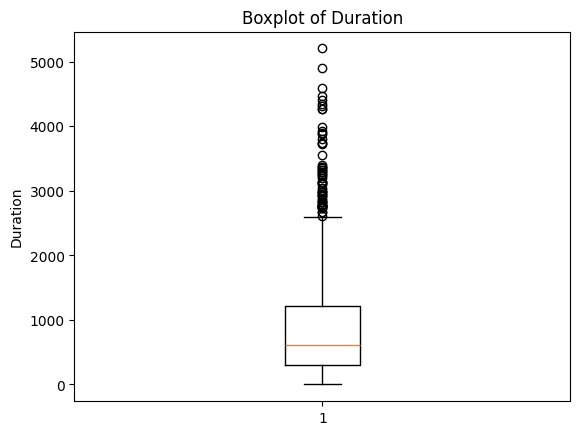

In [ ]:
import matplotlib.pyplot as plt

# Check summary statistics for `duration`
print(attrition_df_final['duration'].describe())

# Calculate IQR
q1 = attrition_df_final['duration'].quantile(0.25)
q3 = attrition_df_final['duration'].quantile(0.75)
iqr = q3 - q1

# Define outlier boundaries
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Print outlier thresholds
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Check for outliers
outliers = attrition_df_final[(attrition_df_final['duration'] < lower_bound) | (attrition_df_final['duration'] > upper_bound)]
print(f"Number of Outliers: {len(outliers)}")

# Plot a boxplot
plt.boxplot(attrition_df_final['duration'].dropna())
plt.title('Boxplot of Duration')
plt.ylabel('Duration')
plt.show()

In [ ]:
# Replace NA in 'duration' with the median
median_duration = attrition_df_final['duration'].median()
attrition_df_final['duration'].fillna(median_duration, inplace=True)

# Verify
print(attrition_df_final['duration'].isna().sum())

0


<ipython-input-42-aef445eea3e8>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  attrition_df_final['duration'].fillna(median_duration, inplace=True)
<ipython-input-42-aef445eea3e8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attrition_df_final['duration'].fillna(median_duration, inplace=True)


In [ ]:
# Calculate the mode of participant_masked
mode_participant_masked = attrition_df_final['participant_masked'].mode()[0]

# Fill missing values with the mode
attrition_df_final['participant_masked'].fillna(mode_participant_masked, inplace=True)

# Verify
print(attrition_df_final['participant_masked'].isna().sum())

0


<ipython-input-43-4abfdfe335d8>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  attrition_df_final['participant_masked'].fillna(mode_participant_masked, inplace=True)
<ipython-input-43-4abfdfe335d8>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  attrition_df_final['participant_masked'].fillna(mode_participan

## **3. Export Final Dataset**

In [ ]:
attrition_df_final.to_csv('/content/drive/MyDrive/Final_Clean_ClinicalTrials.csv', index=False)